# Federating a K-means cluster algorithm

In this notebook we show how to use FLEXible to federate a *unsupervised* learning model. We federate the K-means clustering algorithm provided in the [sklearn library](https://scikit-learn.org/stable/modules/clustering.html#k-means).

As usual, we first download and split the dataset we are going to use in this notebook:

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
# Generate train-test splits
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

Next, we federate it using FLEXible, we generate a iid distribution as follows:

In [14]:
from flex.data import FlexDataDistribution, FlexDataObject

train_iris = FlexDataObject(X_train, y_train)
test_iris = FlexDataObject(X_test, y_test)

federated_iris = FlexDataDistribution.iid_distribution(train_iris, n_clients=5)

Now, we present a centralized K-means model and evaluate it, the main objective of this notebook is showing how to federate such model using FLEXible. The performance is assessed by several clustering metrics (see [this link](https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation)).

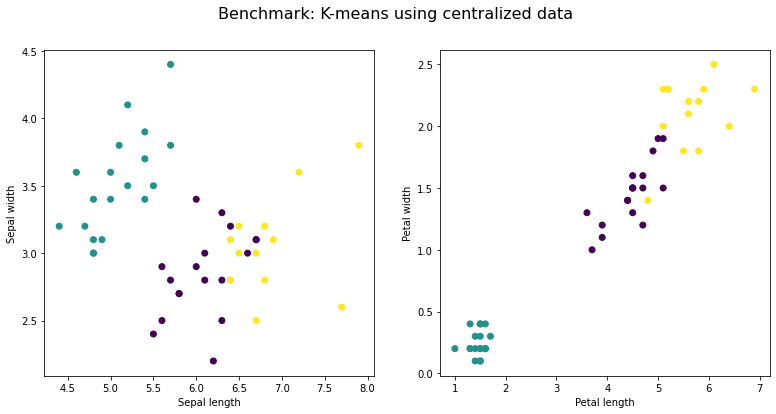

In [26]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def plot_k_means(km, test_data, title):
    preds=km.predict(test_data)
    fig, axes=plt.subplots(1, 2, figsize=(13,6))
    fig.suptitle(title, fontsize=16)
    axes[0].scatter(test_data[:, 0], test_data[:, 1], c=preds)
    axes[0].set_xlabel('Sepal length')
    axes[0].set_ylabel('Sepal width')
    
    axes[1].scatter(test_data[:, 2], test_data[:, 3], c=preds)
    axes[1].set_xlabel('Petal length')
    axes[1].set_ylabel('Petal width')
    
centralized_model = KMeans(n_clusters=3)
centralized_model.fit(train_iris.X_data)
plot_k_means(centralized_model, test_iris.X_data, title="Benchmark: K-means using centralized data")

In [16]:
from sklearn import metrics

def score_model(labels, preds):
    
    homogeneity_score = metrics.homogeneity_score(labels, preds)
    completeness_score = metrics.completeness_score(labels, preds)
    v_measure_score = metrics.v_measure_score(labels, preds)
    adjusted_rand_score = metrics.adjusted_rand_score(labels, preds)

    results = homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score
    
    print("-------------------------------------")
    print("Homogeneity: {},\nCompleteness: {},\nV-measure: {},\nRand index (adjusted): {}".format(*results))
    print("-----------------------------------")
    
print("Centralized model scores")
preds = centralized_model.predict(test_iris.X_data)
score_model(test_iris.y_data, preds)

Centralized model scores
-------------------------------------
Homogeneity: 0.7611292159119625,
Completeness: 0.7665813485366475,
V-measure: 0.7638455533689679,
Rand index (adjusted): 0.7584068353040053
-----------------------------------


## The federation process begins!

### Solution details
Since the labels of clusters can vary among each node, we cannot average the centroids right away. 
One solution is to choose the lowest distance average: this is achieved by simply applying the K-means algorithm to the centroids coordinates of all nodes.

Note that this implementation is based on the assumption that the number of clusters has been previously fixed across the clients, so it only works properly in IID scenarios.

### Implementation in FLEXible

The implementation of a federated algorithm in FLEXible always begins with the same steps: 
1. Defining a function to initialize the model in the server node. Note that function `build_server_model` is decorated with decorator `init_server_model`, in this way, we only need to care about loading a model in a FlexModel object.
1. Creating an architecture, in this case, a client server architecture by means of `client_server_architecture`. Note that, the number of clients is provided in `federated_iris` and it can be retrieved using `len(federated_iris)`. 

The `FlexPool` generated contains 20 clients an 1 server, which is also an aggregator node. Remember that nodes in a `FlexPool` communicate with each other using the `map` function.

In [17]:
from flex.pool import init_server_model
from flex.pool import FlexPool, FlexModel


@init_server_model
def build_server_model(n_clusters=10):
    flex_model = FlexModel()
    flex_model.model = KMeans(n_clusters=n_clusters)
    flex_model.model._n_threads = 1
    return flex_model


p = FlexPool.client_server_architecture(
    federated_iris, init_func=build_server_model, n_clusters=3
)

clients = p.clients
servers = p.servers
aggregators = p.aggregators

print(f"Number of nodes in the pool {len(p)}: {len(servers)} servers plus {len(clients)} clients. The server is also an aggregator")

Number of nodes in the pool 11: 1 servers plus 10 clients. The server is also an aggregator


Now, we provide a way to deploy the FlexModel in the server node to the clients node. Again, note that we decorate the function with `deploy_server_model`, so that we can focus on implementing a way of copying the server model. Thanks to the decorator, the job of copying the model in each client is done by FLEXible automagically.

In [18]:
import copy

from flex.pool import deploy_server_model

@deploy_server_model
def copy_server_model_to_clients(server_flex_model: FlexModel):
    flex_model = FlexModel()
    for k, v in server_flex_model.items():
        flex_model[k] = copy.deepcopy(v)

    return flex_model

servers.map(copy_server_model_to_clients, clients)

Once the models are loaded into the clients, we can proceed to train them:

In [19]:
def train(client_flex_model: FlexModel, client_data: FlexDataObject):
    client_flex_model.model.fit(client_data.X_data)

clients.map(train)

Thanks to the decorator `collect_client_weights`, we only need to provide a way to get the trained weights of one client and FLEXible will do it for each client. Note that, in this architecture servers are the same as aggregators, therefore we can replace the last line below with: `servers.map(get_client_weights, clients)`.

In [20]:
from flex.pool import collect_clients_weights

@collect_clients_weights
def get_clients_weights(client_flex_model: FlexModel):
    return client_flex_model.model.cluster_centers_

aggregators.map(get_clients_weights, clients)
# The same as:
# servers.map(get_client_weights, clients)

With the `aggregate_weights` decorator, we only need to implement our aggregator and FLEXible will apply it and store the result inside the FlexModel of the aggregator using internally the key "aggregated_weights". As stated before in this architecture servers are the same as aggregators, therefore we can replace the last line below with: `servers.map(aggregate)`.

In [21]:
from flex.pool import aggregate_weights
import numpy as np

@aggregate_weights
def aggregate(list_of_weights: list):
    weight_arr = np.concatenate(list_of_weights)
    n_clusters = len(list_of_weights[0])
    model_aggregator = KMeans(n_clusters=n_clusters)
    model_aggregator.fit(weight_arr)
    return model_aggregator.cluster_centers_

# Aggregate weights
aggregators.map(aggregate)
# The same as:
# servers.map(aggregate)

Once we have aggregated the weights, it is required to provide a way to set them in the server. The decorator `set_aggregated_weights` allow us to focus only in implementing a way to set the weights, the rest is done by FLEXible automagically.

In [22]:
from flex.pool import set_aggregated_weights

@set_aggregated_weights
def set_agreggated_weights_to_server(server_flex_model: FlexModel, aggregated_weights):
    server_flex_model.model.cluster_centers_ = aggregated_weights

# Set aggregated weights in the server model
aggregators.map(set_agreggated_weights_to_server, servers)
# The same as:
# servers.map(set_agreggated_weights_to_server, servers)

Alright, we have have completed an entire federated round so it is time to see the results. Thanks to the decorator  `evaluate_server_model` we can focus on evaluating the results of the FlexModel stored in the server node.

-------------------------------------
Homogeneity: 0.8225452696615719,
Completeness: 0.8225452696615718,
V-measure: 0.8225452696615719,
Rand index (adjusted): 0.8432759439997076
-----------------------------------


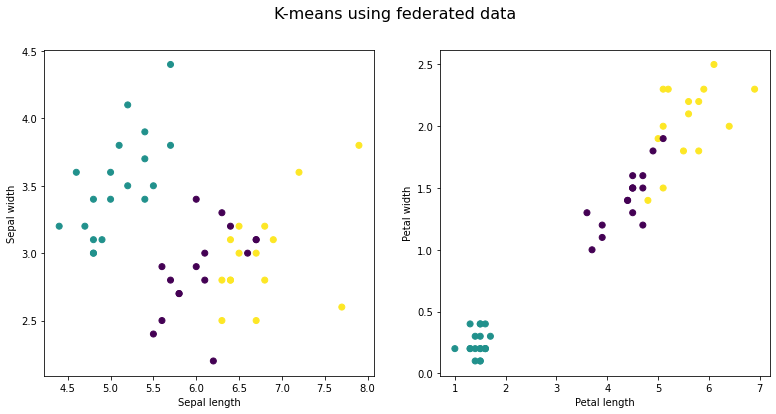

In [23]:
from flex.pool import evaluate_server_model

@evaluate_server_model
def evaluate_global_model(server_flex_model: FlexModel, test_data=None):
    preds = server_flex_model.model.predict(test_data.X_data)
    plot_k_means(server_flex_model.model, test_data.X_data, title="K-means using federated data")
    score_model(test_data.y_data, preds)

servers.map(evaluate_global_model, test_data=test_iris)

### Run the federated learning experiment for a few rounds

Now, we can summarize the steps provided above and run the federated experiment for multiple rounds:

Federated model scores
-------------------------------------
Homogeneity: 0.8225452696615719,
Completeness: 0.8225452696615719,
V-measure: 0.8225452696615719,
Rand index (adjusted): 0.8432759439997076
-----------------------------------


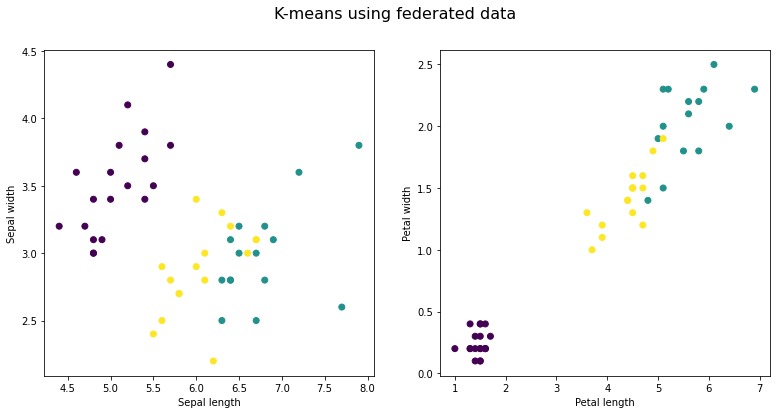

In [24]:
n_rounds = 5
p = FlexPool.client_server_architecture(
    federated_iris, init_func=build_server_model, n_clusters=3
)
servers = p.servers
clients = p.clients
aggregators = p.aggregators

for i in range(n_rounds):
    servers.map(copy_server_model_to_clients, clients)
    clients.map(train)
    aggregators.map(get_clients_weights, clients)
    aggregators.map(aggregate)
    aggregators.map(set_agreggated_weights_to_server, servers)

print("Federated model scores")
servers.map(evaluate_global_model, test_data=test_iris)

Centralized model scores
-------------------------------------
Homogeneity: 0.7611292159119625,
Completeness: 0.7665813485366475,
V-measure: 0.7638455533689679,
Rand index (adjusted): 0.7584068353040053
-----------------------------------


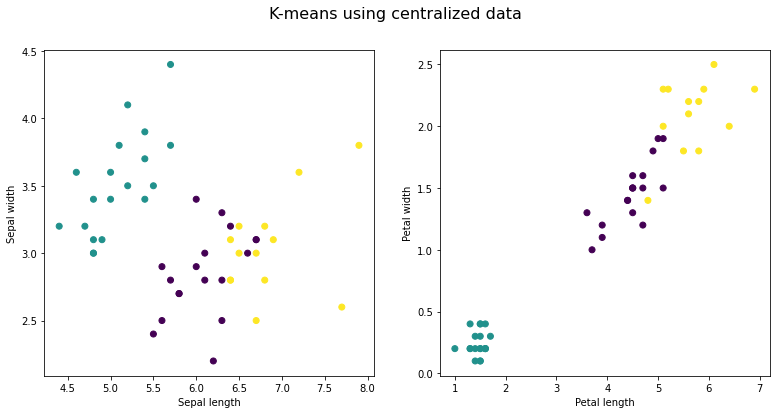

In [25]:
print("Centralized model scores")
preds = centralized_model.predict(test_iris.X_data)
score_model(test_iris.y_data, preds)
plot_k_means(centralized_model, test_iris.X_data, title="K-means using centralized data")